# Deep Learning - Project 2 - Convolutional Neural Networks


## Part 1 - Implementation of an image classifier

### 0) Imports

In [85]:
import os
import math
import numpy as np 
import time
from collections import Counter

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline 
from PIL import Image

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from time import sleep

In [86]:
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print("Using torch", torch.__version__)

Using torch 1.13.1+cpu


In [87]:
# set seeds for reproducibility
torch.manual_seed(8)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### 1) Download the data and load it in the Notebook

In [88]:
caltech_data = dset.Caltech101("data", target_type="category", download=True)
categories = caltech_data.categories

Files already downloaded and verified


Number of samples:  8677


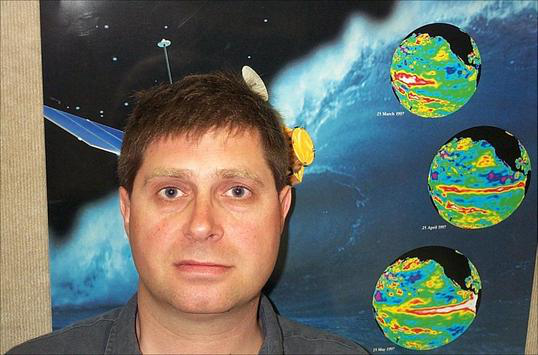

target: Faces, shape: (355, 538, 3)


In [89]:
print('Number of samples: ', len(caltech_data))
img, target = caltech_data[3] # fourth sample
display(img)
print(f"target: {categories[target]}, shape: {np.array(img).shape}")

### 2) Standardize the images

In [90]:
transform_img = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x) # unify number of channels
])

caltech_data = dset.Caltech101("data", transform=transform_img, target_type="category", download=True)

Files already downloaded and verified


In [91]:
def mean_and_std(loader):
    counter = 0
    ev = torch.empty(3)
    var = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        number_of_pixels = b * h * w
        # sums over each channel
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        # expected value
        ev = (counter * ev + sum_) / (counter + number_of_pixels)
        # variance
        var = (counter * var + sum_of_square) / (counter + number_of_pixels)
        counter += number_of_pixels

    mean, std = ev, torch.sqrt(var - ev ** 2)        
    return mean,std

In [92]:
BATCH_SIZE = 4
image_data_loader = torch.utils.data.DataLoader(
  caltech_data, 
  batch_size = BATCH_SIZE, 
  shuffle=False,
  num_workers=0)

mean, std = mean_and_std(image_data_loader)
print(f"Statistics of the whole dataset:\nmean = {mean}\nstd = {std}")

Statistics of the whole dataset:
mean = tensor([0.5390, 0.5173, 0.4887])
std = tensor([0.3056, 0.2996, 0.3121])


In [93]:
# https://www.binarystudy.com/2022/04/how-to-normalize-image-dataset-inpytorch.html 
transform_standardization = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x), # unify number of channels
    transforms.Normalize(mean, std)
])

caltech_data = dset.Caltech101("data", transform=transform_standardization, target_type="category", download=True)

Files already downloaded and verified


In [94]:
# CHECK WHETHER mean == 0 and std == 1
image_data_loader_stand = torch.utils.data.DataLoader(
  caltech_data, 
  batch_size = BATCH_SIZE, 
  shuffle=False,
  num_workers=0)

mean, std = mean_and_std(image_data_loader_stand)
print(f"Statistics of the whole dataset:\nmean = {mean}\nstd = {std}")
assert torch.le(mean.abs(), 0.001).all(), "Not all of the channels have mean equal to 0"
assert torch.isclose(std, torch.ones_like(std), atol=0.001).all(), "Not all of the channels have standard deviation equal to 1"

Statistics of the whole dataset:
mean = tensor([-4.4689e-07, -1.2186e-08,  8.0951e-07])
std = tensor([1.0000, 1.0000, 1.0000])


In [95]:
def display_img_tensor(img):
    images_np = img.numpy()
    img_plt = images_np.transpose(1,2,0)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(np.clip(img_plt, 0, 1))

target: Faces, shape: (3, 256, 256)


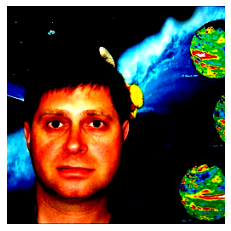

In [96]:
img, target = caltech_data[3]
display_img_tensor(img)
print(f"target: {categories[target]}, shape: {np.array(img).shape}")

### 3) Divide the collection into Train and Test set

In [97]:
# check the number of samples in each class
classes_count = dict(Counter(caltech_data.y))
classes_count = sorted(classes_count.items(), key=lambda item: item[1], reverse=True)
print("(id, number of samples)")
print(*classes_count[:35])

(id, number of samples)
(5, 800) (3, 798) (0, 435) (1, 435) (94, 239) (2, 200) (12, 128) (19, 123) (55, 114) (23, 107) (47, 100) (46, 99) (13, 98) (16, 91) (50, 88) (63, 87) (54, 86) (86, 86) (92, 86) (15, 85) (39, 85) (90, 85) (81, 84) (75, 82) (57, 81) (51, 80) (58, 78) (65, 76) (35, 75) (93, 75) (26, 73) (27, 70) (25, 69) (34, 68) (31, 67)


In [98]:
# take 20 classes with about 80 examples each
N_CLASSES = 20
chosen_classes = [item[0] for item in classes_count[12:12+N_CLASSES]]
res_list = map(categories.__getitem__, chosen_classes)
print("Selected classes:")
print(*res_list)

Selected classes:
brain butterfly helicopter menorah kangaroo starfish trilobite buddha ewer sunflower scorpion revolver laptop ibis llama minaret electric_guitar umbrella crab crayfish


In [99]:
idx, classes = [], []

for i, cl in enumerate(caltech_data.y):
    if cl in chosen_classes:
        idx.append(i)
        classes.append(cl)

In [100]:
# split
train_indices, test_indices = train_test_split(idx, test_size=0.3, stratify=classes)
len(train_indices), len(test_indices)

(1155, 496)

In [101]:
BATCH_SIZE = 4

train_set = torch.utils.data.Subset(caltech_data, train_indices)
test_set = torch.utils.data.Subset(caltech_data, test_indices)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)

In [102]:
def check_sets(loader, show_idx=-1):
    stats_dict = dict()
    i = 0
    for images, labels in loader:
        for  img, lab in zip(images, labels):
          if i == show_idx:
              print('EXEMPLARY IMAGE')
              print(f'Label: {categories[lab]}')
              print(f'Shape: {img.shape}')
              display_img_tensor(img)
          i+=1
          if categories[lab] in stats_dict.keys():
            stats_dict[categories[lab]] += 1
          else:
            stats_dict[categories[lab]] = 1
    return stats_dict

EXEMPLARY IMAGE
Label: laptop
Shape: torch.Size([3, 256, 256])


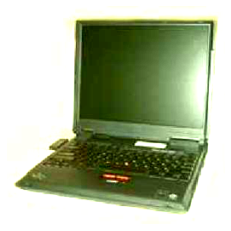

In [103]:
train_stats = check_sets(train_loader, show_idx=10)

EXEMPLARY IMAGE
Label: butterfly
Shape: torch.Size([3, 256, 256])


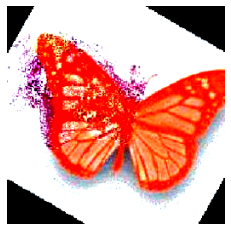

In [104]:
test_stats = check_sets(test_loader, show_idx=10)

In [105]:
assert train_stats.keys() == test_stats.keys()
denom_train = sum(train_stats.values()) # or alternatively len(train_indices)
denom_test = sum(test_stats.values())
print("CHECK CLASS PROPORTIONS IN BOTH SETS:")
for key in train_stats.keys():
    print(f'key: {str.upper(key)}\t\ttrain: {round(train_stats[key]/denom_train*100, 2)}%,\t\ttest: {round(test_stats[key]/denom_test*100,2)}%')

CHECK CLASS PROPORTIONS IN BOTH SETS:
key: KANGAROO		train: 5.19%,		test: 5.24%
key: HELICOPTER		train: 5.37%,		test: 5.24%
key: STARFISH		train: 5.19%,		test: 5.24%
key: REVOLVER		train: 4.94%,		test: 5.04%
key: EWER		train: 5.11%,		test: 5.24%
key: UMBRELLA		train: 4.59%,		test: 4.44%
key: LAPTOP		train: 4.94%,		test: 4.84%
key: ELECTRIC_GUITAR		train: 4.5%,		test: 4.64%
key: CRAB		train: 4.42%,		test: 4.44%
key: SUNFLOWER		train: 5.11%,		test: 5.24%
key: BUDDHA		train: 5.11%,		test: 5.24%
key: SCORPION		train: 5.11%,		test: 5.04%
key: BRAIN		train: 5.97%,		test: 5.85%
key: TRILOBITE		train: 5.19%,		test: 5.24%
key: IBIS		train: 4.85%,		test: 4.84%
key: CRAYFISH		train: 4.24%,		test: 4.23%
key: MINARET		train: 4.59%,		test: 4.64%
key: MENORAH		train: 5.28%,		test: 5.24%
key: BUTTERFLY		train: 5.54%,		test: 5.44%
key: LLAMA		train: 4.76%,		test: 4.64%


In [106]:
# ONE HOT ENCODING
def get_data_one_hot(train_indices, test_indices, caltech_data):
    x = torch.tensor([range(N_CLASSES)])
    one_hot_encoded = F.one_hot(x, num_classes=N_CLASSES)
    one_hot_encoded = torch.squeeze(one_hot_encoded)
    # print(one_hot_encoded.shape)

    train_label_ids = list({caltech_data.y[i] for i in train_indices}) # list from the set of labels, hence can be either train_indices or test_indices
    temp_dict = dict(list(enumerate(train_label_ids)))
    temp_dict_reversed = dict()
    dict_new_label = dict()
    dict_old_label  = dict()

    for key, value in temp_dict.items():
        one_hot = tuple(one_hot_encoded[key].tolist())
        dict_old_label[one_hot] = value
        dict_new_label[value] = one_hot
        temp_dict_reversed[value] = key
    # print(dict_new_label)
    # print(dict_old_label)

    train_data, test_data = [], []
    for idx in train_indices:
        new_label_idx = temp_dict_reversed[caltech_data[idx][1]]
        train_data.append([caltech_data[idx][0],one_hot_encoded[new_label_idx]])
    for idx in test_indices:
        new_label_idx = temp_dict_reversed[caltech_data[idx][1]]
        test_data.append([caltech_data[idx][0],one_hot_encoded[new_label_idx]])
        
    return train_data, test_data, (dict_old_label, dict_new_label)

In [178]:
train_data, test_data, dicts = get_data_one_hot(train_indices, test_indices, caltech_data)

In [108]:
def get_label_from_tensor(tensor, dict_old_label, categories):
    # print(tuple(tensor.tolist()))
    return categories[dict_old_label[tuple(tensor.tolist())]]

sunflower
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])


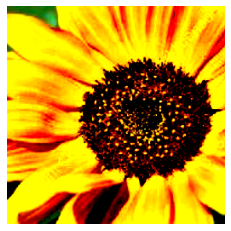

In [109]:
# CHECK TRAIN SET
x = 13
print(get_label_from_tensor(train_data[x][1], dicts[0], categories))
print(train_data[x][1])
display_img_tensor(train_data[x][0])

ibis
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


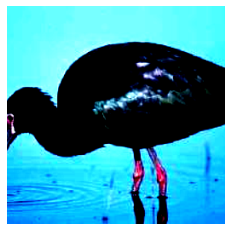

In [110]:
# CHECK TEST SET
x = 29
print(get_label_from_tensor(test_data[x][1], dicts[0], categories))
print(test_data[x][1])
display_img_tensor(test_data[x][0])

### 4) Define the model 

In [111]:
class ConvModel(torch.nn.Module):
    def __init__(self, in_channels, num_of_classes):
        super().__init__()

        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, 32, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Dropout2d(),
                        nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(
                        nn.Conv2d(32, 16, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Dropout2d(),
                        nn.MaxPool2d(2, 2))
        self.conv3 = nn.Sequential(
                        nn.Conv2d(16, 8, kernel_size=3, padding='same'),
                        nn.ReLU(),
                        nn.BatchNorm2d(8),
                        nn.Dropout2d(),
                        nn.MaxPool2d(2, 2))

        self.fc1 = nn.Linear(8192, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, num_of_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [112]:
model = ConvModel(3, N_CLASSES)

# print(f"Model structure: {model}\n\n")
# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

In [113]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 5) Train the model

In [114]:
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [115]:
class EarlyStopper:
    def __init__(self, patience, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_accuracy = -np.inf

    def early_stop(self, test_accuracy):
        if test_accuracy > self.max_accuracy:
            self.max_accuracy = test_accuracy
            self.counter = 0
        elif test_accuracy <= (self.max_accuracy + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [128]:
def train_model(model, optimizer, train_loader, test_loader, loss_module, epochs=250, patience=5):
    model.train()
    # device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    train_accuracy_epochs = list()
    test_accuracy_epochs = list()
    train_loss_epochs = list()
    test_loss_epochs = list()

    early_stopper = EarlyStopper(patience=patience)
    for epoch in range(epochs):
        # TRAIN DATA
        model.train()
        with tqdm(train_loader, unit="batch") as tepoch:
            mul = 1
            correct = 0
            train_loss = 0.0
            for inputs, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch}")

                # inputs = inputs.to(device)
                # labels = labels.to(device)

                preds = model(inputs)
                preds = preds.squeeze(dim=1) # [BATCH_SIZE, 1], change it to [BATCH_SIZE]
                loss = loss_module(preds, labels.float())
                train_loss += loss

                pred_labels = torch.zeros(preds.shape)
                _, max_indices = preds.max(dim=1)
                for i in range(preds.size(0)):
                    pred_labels[i][max_indices[i]] = 1

                correct += torch.sum((pred_labels == labels)*(pred_labels == 1)).item()
                train_accuracy = correct / (BATCH_SIZE * mul)
                mul +=1 

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                tepoch.set_postfix(loss=loss.item(), train_accuracy=train_accuracy)
                
            train_accuracy_epochs.append(train_accuracy)
            train_loss_epochs.append((train_loss/(mul-1)).detach().numpy())
            

        # TEST DATA
        model.eval()
        with tqdm(test_loader, unit="batch") as ttest:
            with torch.no_grad():
                mul = 1
                correct = 0
                test_loss = 0.0
                for inputs, labels in ttest:
                    ttest.set_description(f"Test set:")

                    # inputs = inputs.to(device)
                    # labels = labels.to(device)

                    preds = model(inputs)
                    preds = preds.squeeze(dim=1)
                    loss = loss_module(preds, labels.float())
                    test_loss += loss

                    pred_labels = torch.zeros(preds.shape)
                    _, max_indices = preds.max(dim=1)
                    for i in range(preds.size(0)):
                        pred_labels[i][max_indices[i]] = 1

                    correct += torch.sum((pred_labels == labels)*(pred_labels == 1)).item()
                    test_accuracy = correct / (BATCH_SIZE * mul)
                    mul +=1 

                    ttest.set_postfix(loss=loss.item(), test_accuracy=test_accuracy)
                test_accuracy_epochs.append(test_accuracy)
                test_loss_epochs.append((test_loss/(mul-1)).detach().numpy() )

                # EARLY STOPPING
                if early_stopper.early_stop(test_accuracy):             
                    return train_accuracy_epochs, train_loss_epochs, test_accuracy_epochs, test_loss_epochs

    return train_accuracy_epochs, train_loss_epochs, test_accuracy_epochs, test_loss_epochs

In [129]:
EPOCHS = 2
train_accuracy, train_loss, test_accuracy, test_loss = train_model(model, optimizer, train_loader, test_loader, criterion, epochs=EPOCHS)

Test set:: 100%|██████████| 16/16 [00:09<00:00,  1.68batch/s, loss=2.93, test_accuracy=0.139]


Learning curves

In [130]:
def visualize_stats(train_accuracy, train_loss, test_accuracy, test_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
    x = range(1, EPOCHS+1)
    # ACCURACY
    ax1.plot(x, train_accuracy, label='train accuracy')
    ax1.plot(x, test_accuracy, label='test accuracy')
    ax1.set(xlabel='Epoch', xticks=x, title='Accuracy learning curves')
    ax1.legend()
    # LOSS FUNCTION
    ax2.plot(x, train_loss, label='train loss')
    ax2.plot(x, test_loss, label='test loss')
    ax2.set(xlabel='Epoch', xticks=x, title='Loss function learning curves')
    ax2.legend()
    plt.show()

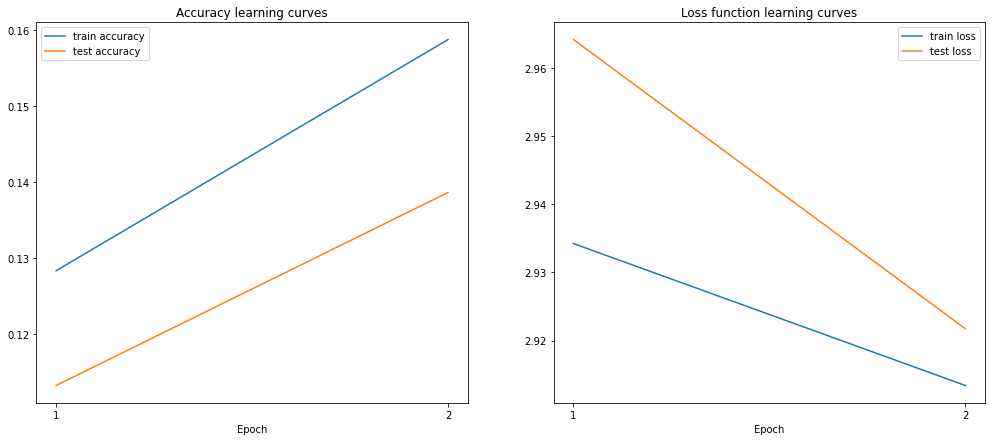

In [131]:
visualize_stats(train_accuracy, train_loss, test_accuracy, test_loss)

Confusion matrices for test data

In [172]:
def evaluate_model(model, data_loader, dict_old_label, categories):
    # device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    y_pred = []
    y_true = []
    model.eval()
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for inputs, labels in data_loader:

            # inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs)
            preds = preds.squeeze(dim=1)

            pred_labels = torch.zeros(preds.shape)
            _, max_indices = preds.max(dim=1)
            for i in range(preds.size(0)):
                pred_labels[i][max_indices[i]] = 1
            
            for pred, true in zip(pred_labels, labels):
                y_pred.append(get_label_from_tensor(pred, dict_old_label, categories))
                y_true.append(get_label_from_tensor(true, dict_old_label, categories))
            
            true_preds += torch.sum((pred_labels == labels)*(pred_labels == 1)).item()
            num_preds += labels.shape[0]

    print(f'Accuracy of the model: {100.0*(true_preds/num_preds):4.2f}%')
    return y_pred, y_true

In [179]:
dict_old_label =dicts[0]
y_pred, y_true = evaluate_model(model, test_loader, dict_old_label, categories)

Accuracy of the model: 14.31%


In [304]:
def get_confusion_matrix(y_true, y_pred):
    # TODO text labels
    cf_matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
    fig, ax = plt.subplots(figsize=(15,15))
    disp.plot(ax=ax, xticks_rotation='vertical')
    ax.set_title('Confusion matrix', fontsize=25)
    plt.show()

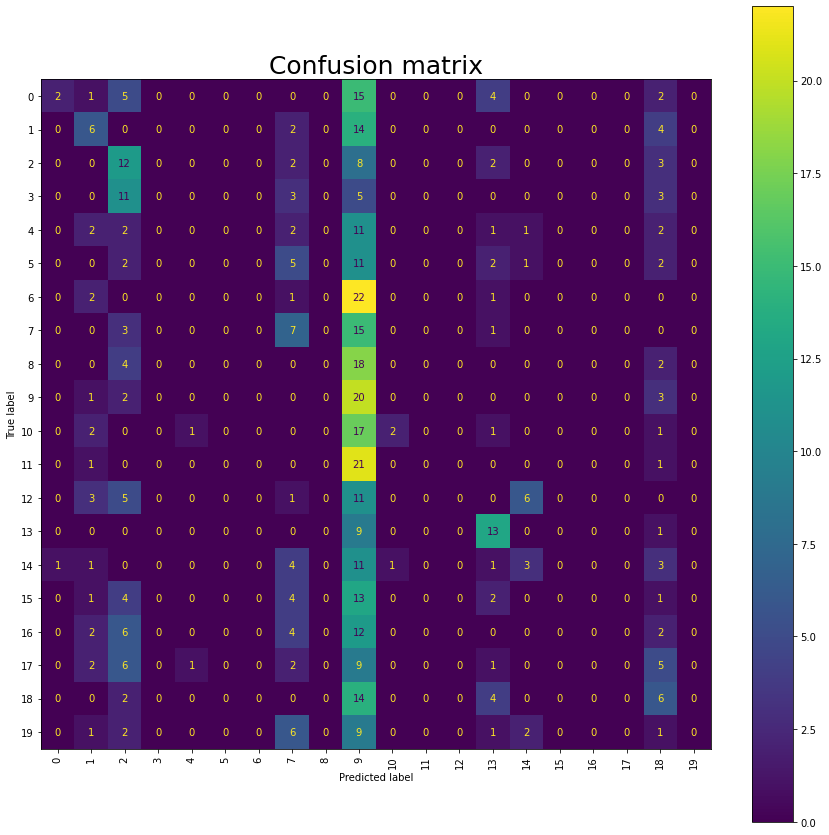

In [305]:
get_confusion_matrix(y_true, y_pred)

In [222]:
def precision_recall_classes(y_true, y_pred, verbose=True):
    labels_set = list(set(y_true))
    starting_dict = {'TP':0, 'FP':0, 'FN':0}
    temp = dict([(label,starting_dict.copy()) for label in labels_set])

    for pred, true in zip(y_pred, y_true):
        # print(true, pred)
        if pred == true:
            temp[pred]['TP'] += 1
        else:
            temp[true]['FN'] += 1
            temp[pred]['FP'] += 1
    stats = dict()
    for key, summary in temp.items():
        if (summary['TP']+summary['FP']) != 0:
            precision = summary['TP']/(summary['TP']+summary['FP'])
        else:
            precision = 0
        if (summary['TP']+summary['FN']) != 0:
            recall = summary['TP']/(summary['TP']+summary['FN'])
        else:
            recall = 0
        stats[key] = {'precision':precision, 'recall':recall}
        if verbose: 
            print(f'LABEL: {str.upper(key)}     \t\tprecision: {precision*100:3.2f}%, recall: {recall*100:3.2f}%')
    return stats


In [223]:
stats = precision_recall_classes(y_true, y_pred)

LABEL: SUNFLOWER     		precision: 0.00%, recall: 0.00%
LABEL: LLAMA     		precision: 0.00%, recall: 0.00%
LABEL: BRAIN     		precision: 66.67%, recall: 6.90%
LABEL: EWER     		precision: 0.00%, recall: 0.00%
LABEL: SCORPION     		precision: 0.00%, recall: 0.00%
LABEL: TRILOBITE     		precision: 14.29%, recall: 23.08%
LABEL: KANGAROO     		precision: 7.55%, recall: 76.92%
LABEL: UMBRELLA     		precision: 0.00%, recall: 0.00%
LABEL: HELICOPTER     		precision: 16.28%, recall: 26.92%
LABEL: BUDDHA     		precision: 24.00%, recall: 23.08%
LABEL: BUTTERFLY     		precision: 18.18%, recall: 44.44%
LABEL: STARFISH     		precision: 0.00%, recall: 0.00%
LABEL: MINARET     		precision: 38.24%, recall: 56.52%
LABEL: ELECTRIC_GUITAR     		precision: 0.00%, recall: 0.00%
LABEL: CRAYFISH     		precision: 0.00%, recall: 0.00%
LABEL: CRAB     		precision: 0.00%, recall: 0.00%
LABEL: LAPTOP     		precision: 66.67%, recall: 8.33%
LABEL: REVOLVER     		precision: 23.08%, recall: 12.00%
LABEL: IBIS     		pr

In [292]:
def show_prediction(model, data, dict_old_label, categories):
    input, label = data[0], data[1]
    model.eval()
    input = input[None, :]
    pred = model(input)
    pred = pred.squeeze(dim=0)
    print('PROBABILITIES:')
    print(pred.detach().numpy())
    
    pred_label = torch.zeros(pred.shape)
    _, max_idx = pred.max(dim=0)
    pred_label[max_idx] = 1
    pred_label = pred_label.squeeze(dim=0)
    print('\nPREDICTION:')
    print(f'{pred_label.detach().numpy()} -> {get_label_from_tensor(pred_label, dict_old_label, categories)}')
    print('TRUE CLASS:')
    print(f'{label.numpy().astype(float)} -> {get_label_from_tensor(label, dict_old_label, categories)}')
    
    
    display_img_tensor(input[0])

PROBABILITIES:
[8.6004503e-02 1.8160833e-03 7.3208827e-01 2.0481466e-04 2.4421472e-04
 1.1182589e-05 3.8866117e-05 3.2641790e-03 7.9046114e-04 3.2303433e-04
 5.7887981e-05 3.3941299e-03 5.5123115e-04 8.2092602e-03 5.5542262e-04
 2.8741997e-05 1.9353606e-02 7.9938461e-04 1.4207901e-01 1.8569984e-04]

PREDICTION:
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -> butterfly
TRUE CLASS:
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -> butterfly


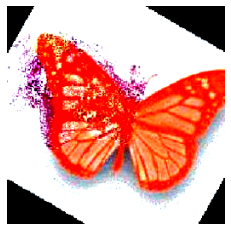

In [293]:
# CLASSIFIED CORRECTLY
x = 10
show_prediction(model, test_data[x], dict_old_label, categories)

PROBABILITIES:
[5.23301196e-06 1.08429030e-01 5.65935508e-04 1.18488915e-05
 2.37382334e-02 1.09535802e-06 3.81433256e-06 6.39158726e-01
 2.21901317e-03 2.20439941e-01 6.54678850e-04 9.15455530e-05
 1.70493831e-06 1.25072460e-04 1.46411161e-03 3.43822194e-06
 4.18864365e-05 2.97314348e-03 6.58916542e-05 5.65988648e-06]

PREDICTION:
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] -> helicopter
TRUE CLASS:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] -> starfish


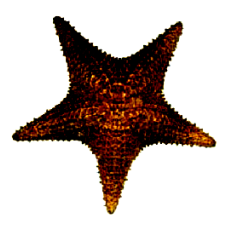

In [295]:
# CLASSIFIED INCORRECTLY
x = 17
show_prediction(model, test_data[x], dict_old_label, categories)

### 6) Save the model to disk

In [301]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model_object, path):
    return model_object.load_state_dict(torch.load(path))

In [302]:
save_model(model, 'model/model.pth')
new_model = ConvModel(3, N_CLASSES)
load_model(new_model, 'model/model.pth')

<All keys matched successfully>

Check whether it works properly

Accuracy of the model: 14.31%


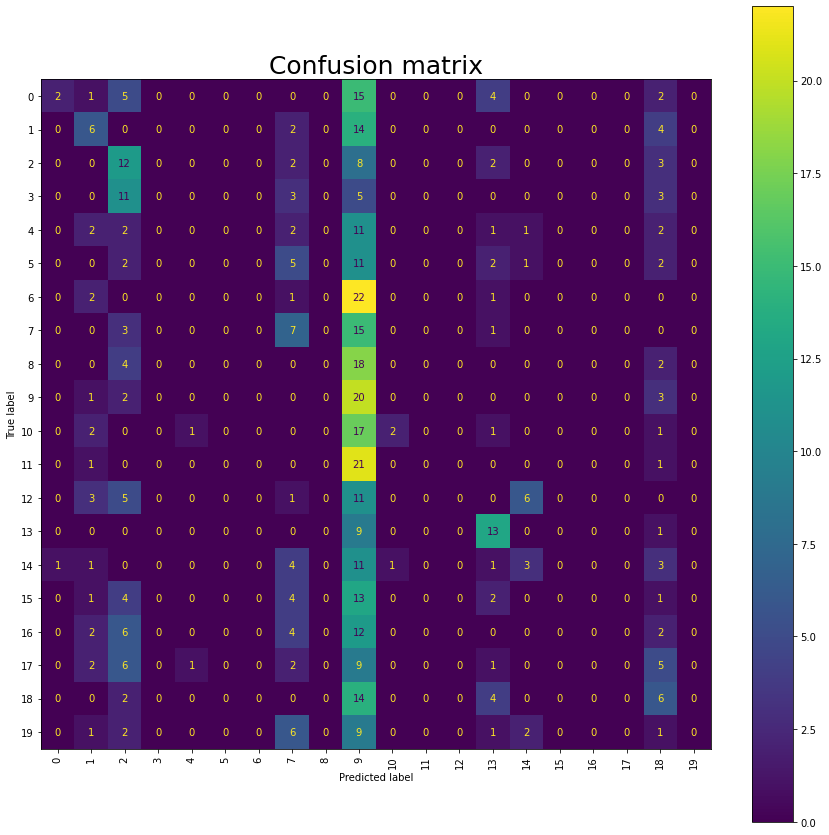

In [306]:
y_pred, y_true = evaluate_model(new_model, test_loader, dict_old_label, categories)
get_confusion_matrix(y_true, y_pred)

### 7) Summary of the Part 1 - describe your observations

## Part 2 - Experimental comparative analysis

In [ ]:
# choose >= 3 tasks